In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# parameters for ORION


CHANNEL_NAMES = ["Hoechst", "CD31", "CD45", "CD68","CD4", "FOXP3", "CD8a",
                 "CD45RO", "CD20", "PD-L1", "CD3e", "CD163", "E-cadherin", "PD-1",
                 "Ki67", "Pan-CK", "SMA"]
EXPRESSION_MATRIX_DIR = ""
OUTPUT_DIR = ""


PARENT_MARKERS = {
    "CD3e": "CD45",  # T cells are a subset of immune cells
    "CD4": "CD3e",  # Helper T cells are a subset of T cells
    "CD8a": "CD3e",  # Cytotoxic T cells are a subset of T cells
    "FOXP3": "CD4",  # Regulatory T cells (Tregs) are a subset of CD4+ T cells
    "CD45RO": "CD3e",  # Memory T cells are a subset of leukocytes
    "CD20": "CD45",  # B cells are a subset of immune cells
    "CD68": "CD45",  # Macrophages are a subset of immune cells
    "CD163": "CD68",  # M2 macrophages are a subset of macrophages
}

In [3]:
csv_paths = [str(fn) for fn in Path(EXPRESSION_MATRIX_DIR).glob("*.csv")]
len(csv_paths)

num_channels = len(CHANNEL_NAMES)
pred_cols = [str(idx) for idx in range(num_channels)]

df_all = []
for csv_path in tqdm(csv_paths):
    slide_name = Path(csv_path).stem
    df_slide = pd.read_csv(csv_path)
    df_slide[pred_cols] = df_slide[pred_cols].astype(np.float16)
    df_slide[['X_centroid', 'Y_centroid']] = df_slide[['X_centroid', 'Y_centroid']].astype(np.int32)
    df_slide["slide_name"] = slide_name
    df_slide["slide_name"] = df_slide["slide_name"].astype("category")
    df_all.append(df_slide)
df_all = pd.concat(df_all, ignore_index=True)
df_all = df_all.rename(columns={str(idx): channel_name for idx, channel_name in enumerate(CHANNEL_NAMES)})

100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


In [4]:
from sklearn.mixture import GaussianMixture

def get_threshold_gmm(df_all, marker_name, log_norm=False, max_cells=None):
    gmm = GaussianMixture(n_components=2, random_state=42)
    data = df_all[df_all[marker_name] > 0][[marker_name]]
    if max_cells:
        n_sample = min(max_cells, len(data))
        data = data.sample(n_sample)
    if log_norm:
        shift_log = 1
        gmm.fit(np.log(data + shift_log))
    else:
        gmm.fit(data)
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    # Find the threshold: intersection of two Gaussians
    mean1, mean2 = sorted(means)
    std1, std2 = np.sqrt(sorted(variances))

    threshold = (mean1 * std2**2 - mean2 * std1**2 + std1 * std2 * \
        np.sqrt((mean1 - mean2)**2 + 2 * (std2**2 - std1**2) * np.log(std2 / std1))) / (std2**2 - std1**2)
    if log_norm:
        threshold = (np.exp(threshold) - shift_log)

    plt.hist(data, bins=255, density=True, alpha=0.5, label="Data Distribution")
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f"Threshold: {threshold:.2f}")
    plt.legend()
    plt.title("Bi-Gaussian Distribution and Thresholding")
    plt.show()
    return gmm, threshold

In [5]:
#gmm, threshold = get_threshold_gmm(df_all, "Pan-CK", log_norm=False, max_cells=int(1e7))

  0%|          | 0/17 [00:00<?, ?it/s]

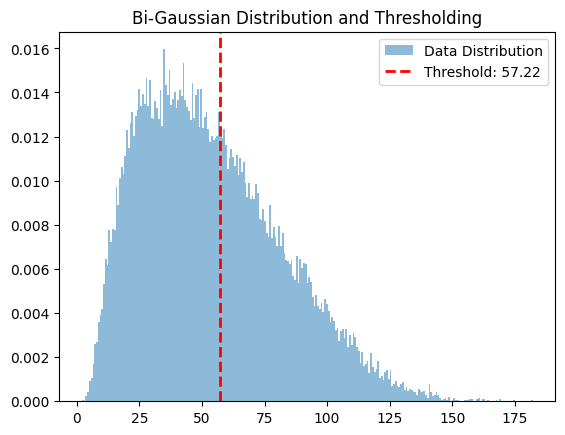

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
  6%|▌         | 1/17 [00:00<00:10,  1.46it/s]

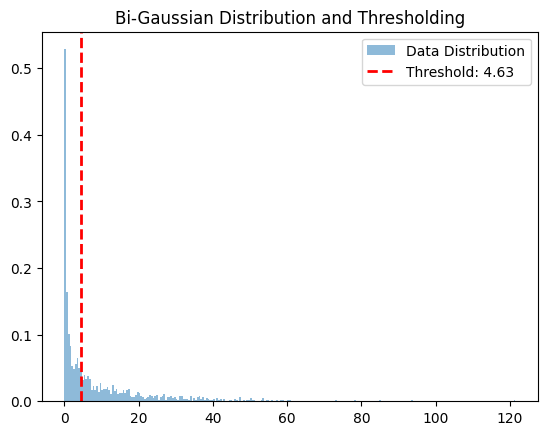

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 12%|█▏        | 2/17 [00:01<00:08,  1.87it/s]

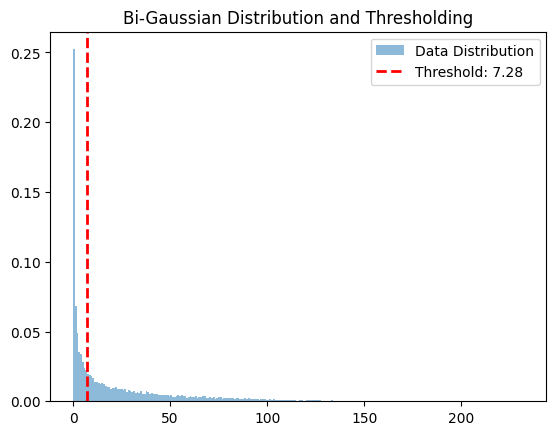

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 18%|█▊        | 3/17 [00:01<00:09,  1.50it/s]

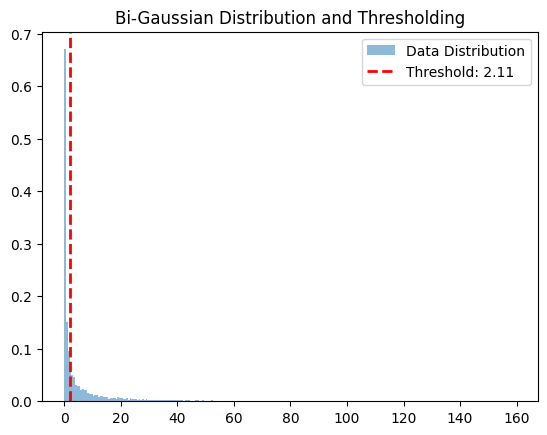

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 24%|██▎       | 4/17 [00:02<00:08,  1.60it/s]

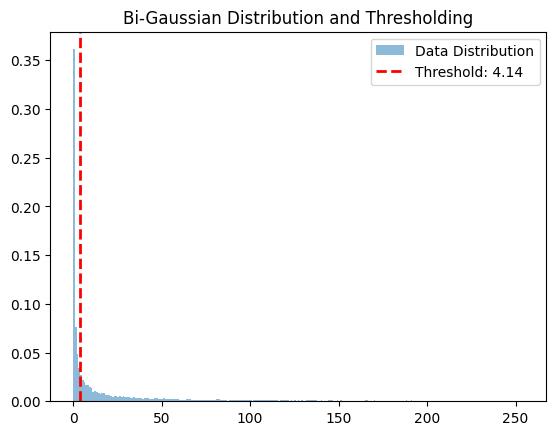

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 29%|██▉       | 5/17 [00:03<00:09,  1.27it/s]

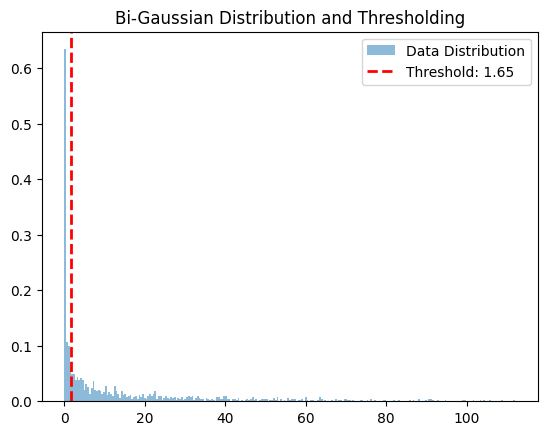

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 35%|███▌      | 6/17 [00:04<00:07,  1.48it/s]

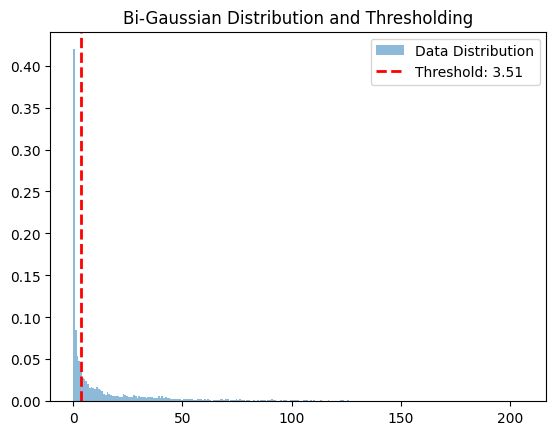

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 41%|████      | 7/17 [00:04<00:06,  1.63it/s]

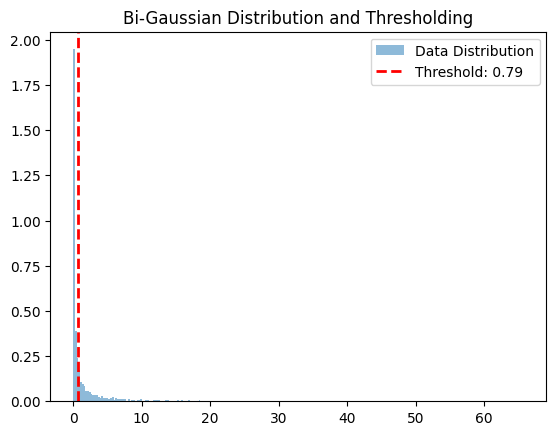

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 47%|████▋     | 8/17 [00:05<00:05,  1.71it/s]

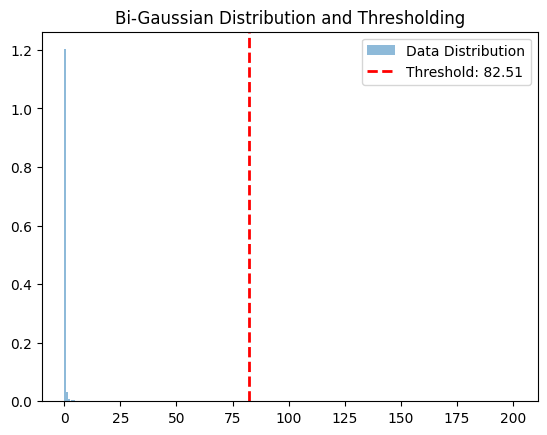

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 53%|█████▎    | 9/17 [00:05<00:04,  1.87it/s]

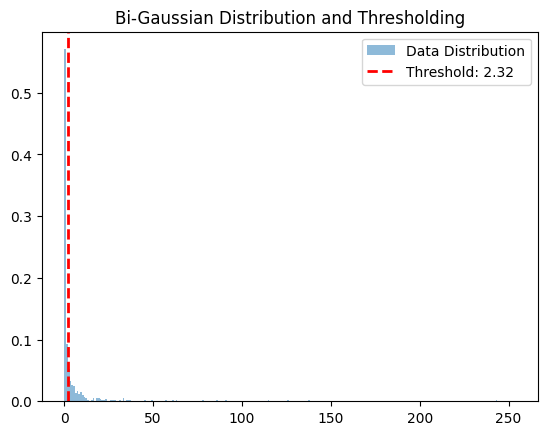

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 59%|█████▉    | 10/17 [00:05<00:03,  2.03it/s]

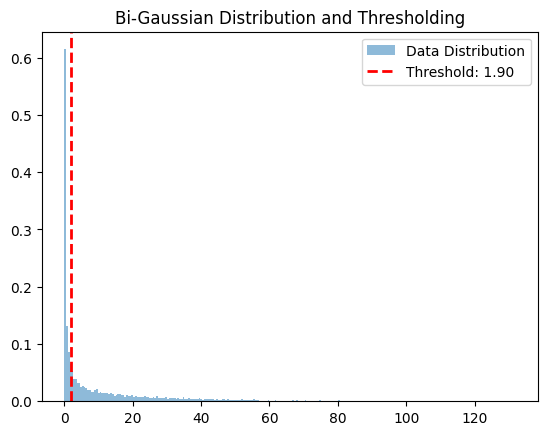

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 65%|██████▍   | 11/17 [00:06<00:02,  2.07it/s]

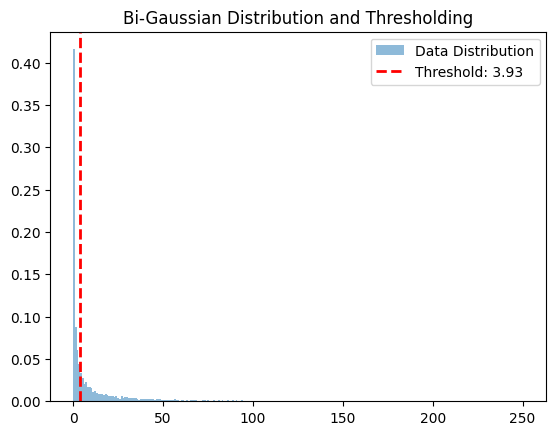

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 71%|███████   | 12/17 [00:06<00:02,  2.11it/s]

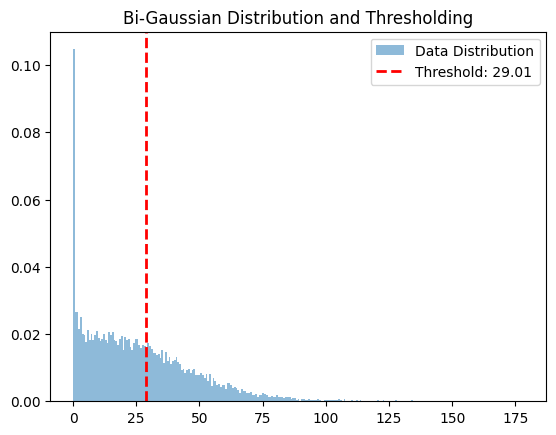

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 76%|███████▋  | 13/17 [00:07<00:02,  1.66it/s]

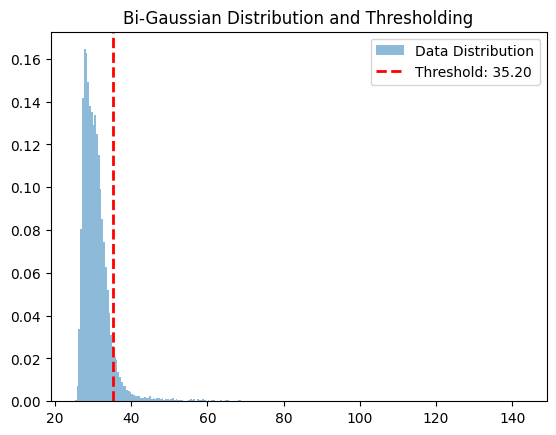

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 82%|████████▏ | 14/17 [00:08<00:01,  1.64it/s]

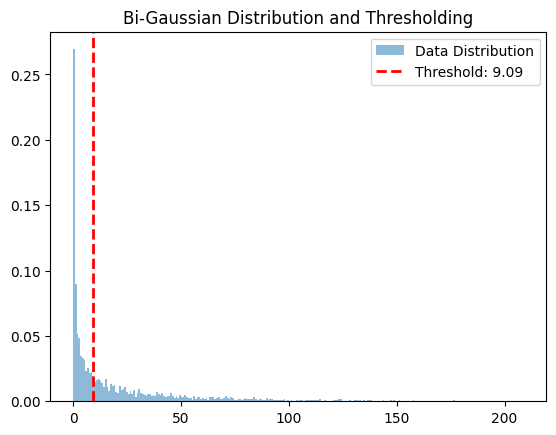

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 88%|████████▊ | 15/17 [00:08<00:01,  1.80it/s]

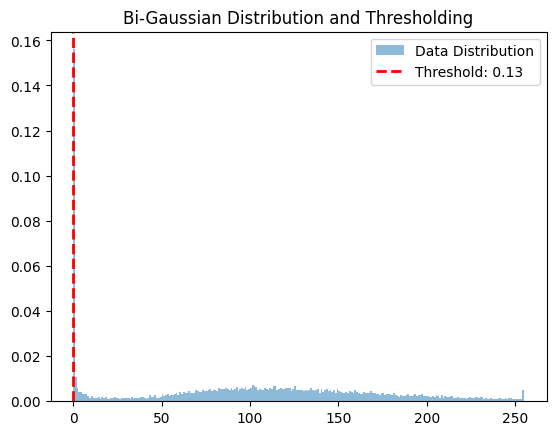

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
 94%|█████████▍| 16/17 [00:10<00:00,  1.12it/s]

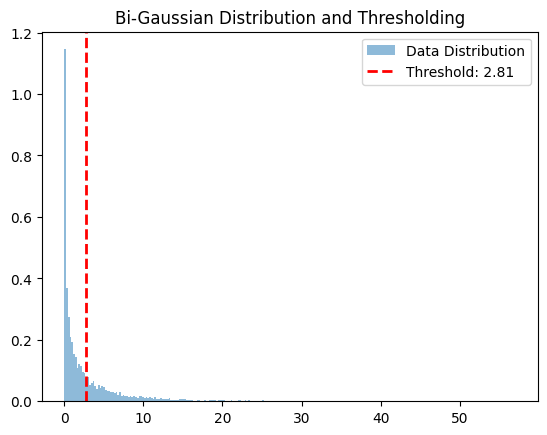

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
100%|██████████| 17/17 [00:11<00:00,  1.52it/s]


In [6]:
for channel_name in tqdm(CHANNEL_NAMES):

    gmm, threshold = get_threshold_gmm(df_all, channel_name, log_norm=False, max_cells=int(1e7))

    high_intensity_component = np.argmax(gmm.means_.flatten())
    probs = np.float32(gmm.predict_proba(df_all[[channel_name]].to_numpy())[:, high_intensity_component])
    #pred = probs > 0.5
    df_all[f"{channel_name}_score"] = probs

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Set threshold for positivity
THRESHOLD_POS = 0.5
THRESHOLD_PARENT = 0.25

# Step 1: Initialize a positivity matrix based on the threshold
pos_matrix = df_all[[f"{channel}_score" for channel in CHANNEL_NAMES]] > THRESHOLD_POS
pos_matrix.columns = [f"{channel}_pos" for channel in CHANNEL_NAMES]

# Step 2: Apply parent-child constraints
for child, parent in PARENT_MARKERS.items():
    child_pos_col = f"{child}_pos"
    parent_score_col = f"{parent}_score"
    
    # If the parent is too low (<0.25), the child cannot be positive
    pos_matrix.loc[df_all[parent_score_col] < THRESHOLD_PARENT, child_pos_col] = False

# Step 3: Assign the updated positivity matrix back to df_all
for column in pos_matrix.columns:
    df_all[column] = pos_matrix[column]

# Step 5: Final manual constraints
df_all["Pan-CK_pos"] = df_all["Pan-CK_pos"] & ~df_all["CD45_pos"]
df_all["E-cadherin_pos"] = df_all["E-cadherin_pos"] & ~df_all["CD45_pos"]

In [8]:
df_all = df_all.rename(columns={"X_centroid": "x", "Y_centroid": "y"})
df_all = df_all.drop(columns=["area"] + CHANNEL_NAMES + ["Hoechst_pos"])

In [9]:
Path(OUTPUT_DIR).mkdir(exist_ok=True)

for slide_name, df_slide in tqdm(df_all.groupby("slide_name")):
    df_slide = df_slide.drop(columns=["slide_name"])
    df_path = Path(OUTPUT_DIR) / f"{slide_name}.csv"
    df_slide.to_csv(
        df_path,
        index=False)

/tmp/ipykernel_13783/3504833354.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for slide_name, df_slide in tqdm(df_all.groupby("slide_name")):
100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
